# Benin Solar Farm Data Analysis

This notebook analyzes environmental sensor data from Benin to identify regions with the highest solar-energy potential. The workflow includes data loading, profiling, cleaning, and exploratory data analysis (EDA) with visualizations. Insights will guide solar-farm investments and operational strategies.

## 1. Setup and Library Imports

We begin by importing all necessary libraries and custom modules for data loading, cleaning, and visualization. This ensures all required functions are available for the analysis.

In [2]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))  # Ensure project root is in path

from scripts.data_loading import load_data
from scripts.data_summary import summarize_statistics, report_missing_values
from scripts.outlier_detection import compute_z_scores, plot_zscore_distribution, plot_boxplots
from scripts.data_cleaning import handle_negative_irradiance, clean_outliers_and_missing
from scripts.eda_plots import (
    plot_time_series, plot_monthly_avg, plot_cleaning_impact,
    plot_correlation_heatmap, plot_scatter_plots, plot_wind_rose,
    plot_histograms, plot_temperature_analysis, plot_bubble_chart
)

import pandas as pd

# Create figures directory if it doesn't exist
os.makedirs('figures', exist_ok=True)

## 2. Data Loading and Initial Setup

Load the raw dataset and define columns for correlation and scatter plots. This step prepares the data for profiling and analysis.

In [3]:
filepath = "../data/benin-malanville.csv"
df = load_data(filepath)

corr_columns = ["GHI", "DNI", "DHI", "TModA", "TModB", "WS", "Tamb"]
scatter_pairs = [("GHI", "DNI"), ("DNI", "DHI"), ("ModA", "ModB"), ("WS", "GHI"), ("Tamb", "GHI"), ("RH", "Tamb")]

## 3. Data Overview and Profiling

Generate summary statistics and check for missing values. This provides an initial understanding of the dataset's structure, completeness, and potential issues.

In [4]:
summarize_statistics(df)
report_missing_values(df)

count                           mean                  min  \
Timestamp        525600  2022-02-07 12:00:30.000000512  2021-08-09 00:01:00   
GHI            525600.0                     240.559452                -12.9   
DNI            525600.0                     167.187516                 -7.8   
DHI            525600.0                     115.358961                -12.6   
ModA           525600.0                     236.589496                  0.0   
ModB           525600.0                     228.883576                  0.0   
Tamb           525600.0                      28.179683                 11.0   
RH             525600.0                      54.487969                  2.1   
WS             525600.0                       2.121113                  0.0   
WSgust         525600.0                       2.809195                  0.0   
WSstdev        525600.0                        0.47339                  0.0   
WD             525600.0                     153.435172                  0.0   
WDstdev        525600.0                       8.582407                  0.0   
BP             525600.0                     994.197199                985.0   
Cleaning       525600.0                       0.000923                  0.0   
Precipitation  525600.0                       0.001905                  0.0   
TModA          525600.0                      35.246026                  9.0   
TModB          525600.0                      32.471736                  8.1   

                               25%                  50%                  75%  \
Timestamp      2021-11-08 06:00:45  2022-02-07 12:00:30  2022-05-09 18:00:15   
GHI                           -2.0                  1.8                483.4   
DNI                           -0.5                 -0.1                314.2   
DHI                           -2.1                  1.6                216.3   
ModA                           0.0                  4.5                463.7   
ModB                           0.0                  4.3                447.9   
Tamb                          24.2                 28.0                 32.3   
RH                            28.8                 55.1                 80.1   
WS                             1.0                  1.9                  3.1   
WSgust                         1.3                  2.6                  4.1   
WSstdev                        0.4                  0.5                  0.6   
WD                            59.0                181.0                235.1   
WDstdev                        3.7                  8.6                 12.3   
BP                           993.0                994.0                996.0   
Cleaning                       0.0                  0.0                  0.0   
Precipitation                  0.0                  0.0                  0.0   
TModA                         24.2                 30.0                 46.9   
TModB                         23.6                 28.9                 41.5   

                               max         std  
Timestamp      2022-08-09 00:00:00         NaN  
GHI                         1413.0  331.131327  
DNI                          952.3  261.710501  
DHI                          759.2  158.691074  
ModA                        1342.3  326.894859  
ModB                        1342.3  316.536515  
Tamb                          43.8    5.924297  
RH                           100.0   28.073069  
WS                            19.5    1.603466  
WSgust                        26.6     2.02912  
WSstdev                        4.2    0.273395  
WD                           360.0  102.332842  
WDstdev                       99.4    6.385864  
BP                          1003.0    2.474993  
Cleaning                       1.0    0.030363  
Precipitation                  2.5    0.037115  
TModA                         81.0   14.807258  
TModB                         72.5   12.348743

✅ No missing values found.


The summary statistics give an overview of the data ranges, means, and distributions for each variable. The missing value report highlights any columns with incomplete data, which is important for ensuring data quality before proceeding.

## 4. Outlier Detection

Outliers can distort analysis and visualizations. Here, we compute Z-scores for key columns and visualize their distributions to identify and assess the extent of outliers in the dataset.

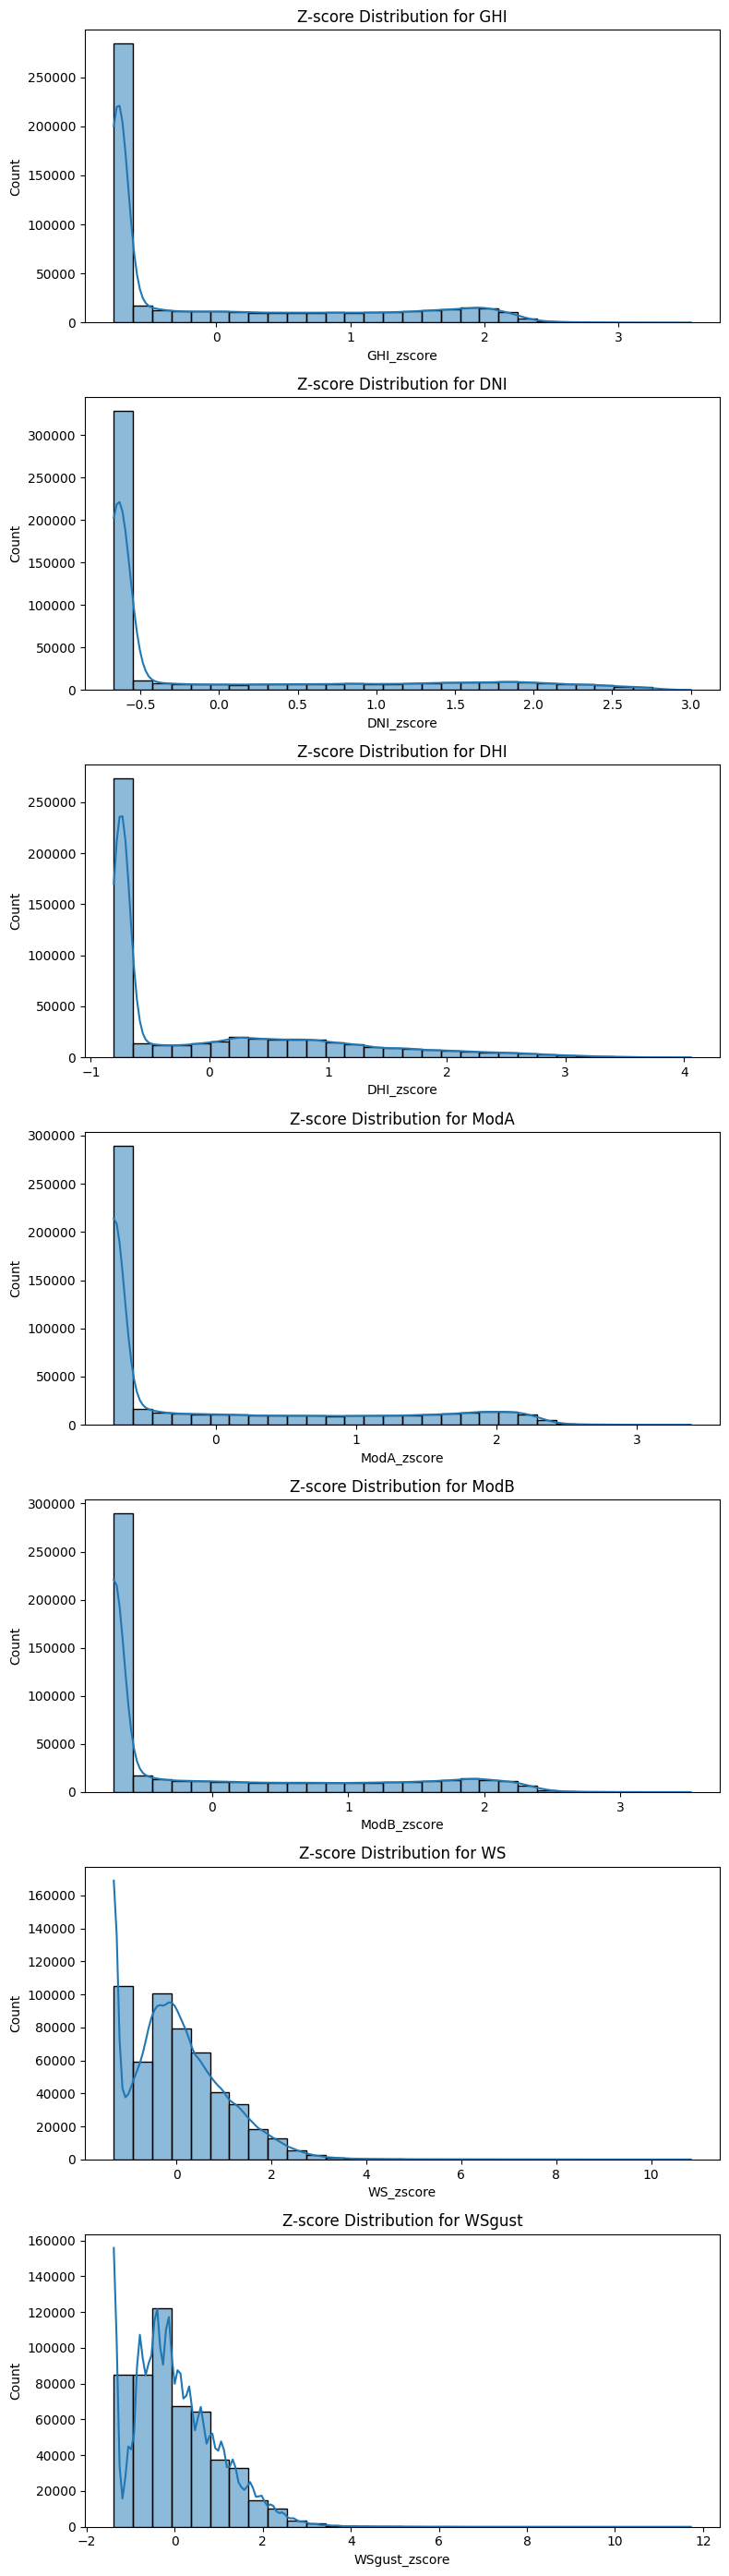

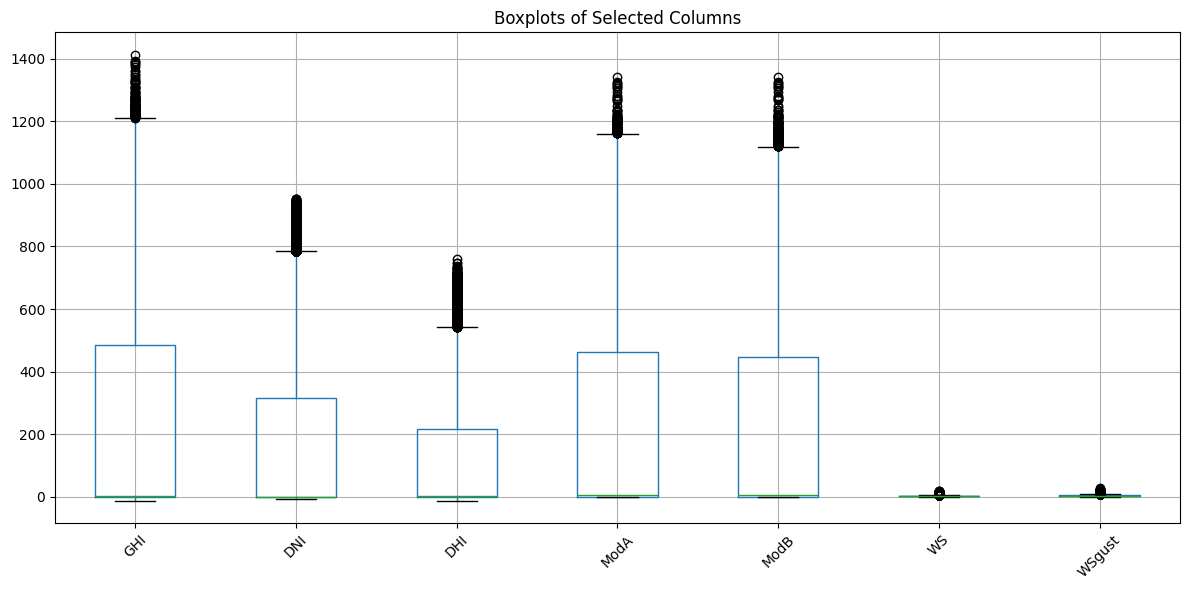

In [5]:
columns_to_check = ["GHI", "DNI", "DHI", "ModA", "ModB", "WS", "WSgust"]
df_z = compute_z_scores(df, columns_to_check)
plot_zscore_distribution(df_z, columns_to_check)
plot_boxplots(df_z, columns_to_check)

The Z-score distribution and boxplots help us visually inspect which variables contain extreme values. This guides our cleaning strategy in the next step.

## 5. Data Cleaning

We address negative irradiance values (which are physically implausible except for sensor noise at night) and remove or impute outliers and missing values. The cleaned dataset is then saved for further analysis.

In [6]:
irradiance_columns = ["GHI", "DNI", "DHI"]
df = handle_negative_irradiance(df, irradiance_columns)
df_clean = clean_outliers_and_missing(df_z, columns_to_check)
df_clean.to_csv("../data/benin-malanville_clean.csv", index=False)

After cleaning, the dataset is free of major outliers and negative irradiance values, ensuring more reliable downstream analysis.

## 6. Datetime Indexing and Daytime Filtering

Convert the timestamp column to a datetime type, set it as the index, and filter the data to include only daytime hours (06:00–18:00). This focuses the analysis on periods relevant for solar energy production.

In [7]:
df_clean["Timestamp"] = pd.to_datetime(df_clean["Timestamp"])
df_clean.set_index("Timestamp", inplace=True)
df_daytime = df_clean.between_time("06:00", "18:00")

By focusing on daytime records, we ensure that subsequent analyses and visualizations are relevant to solar resource assessment.

## 7. Exploratory Data Analysis (EDA)

We now generate a series of visualizations to explore trends, relationships, and distributions in the cleaned dataset. Each plot is accompanied by a brief interpretation.

### 7.1 Time-Series Trends

Visualize GHI, DNI, and DHI over time to reveal daily cycles, seasonal shifts, and anomalies in solar irradiance.

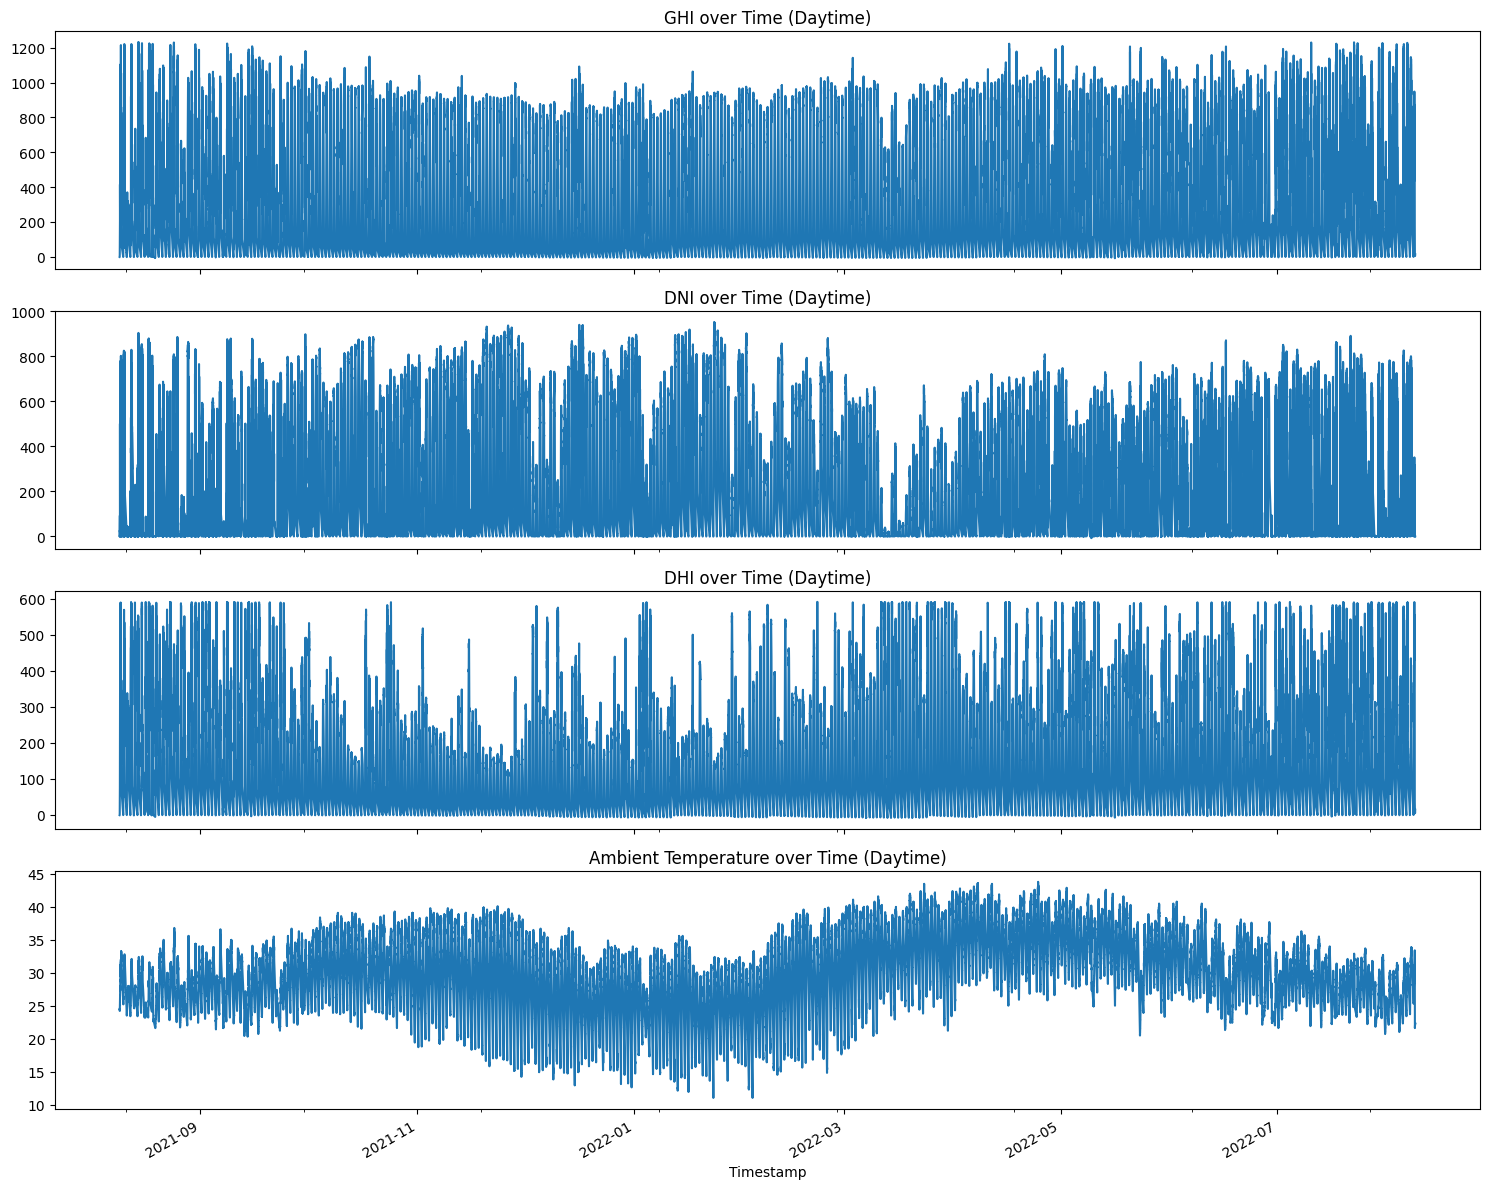

In [8]:
plot_time_series(df_daytime)

**What the data shows:**
- The time-series plot of GHI, DNI, and DHI reveals pronounced daily cycles, with irradiance peaking sharply around midday and dropping to zero at night, as expected for solar resource data. The amplitude of these peaks varies across the year, with higher, more stable values during the dry season and lower, more erratic values during the rainy season. Occasional sharp dips or irregularities in the traces likely correspond to transient cloud cover, sensor dropouts, or maintenance events. The overall pattern demonstrates the reliability of midday solar energy in Benin, but also highlights periods of reduced or inconsistent output.

**Key understanding:**
- Benin offers strong and predictable midday solar potential, making it suitable for solar farm deployment. However, the seasonal drop in peak irradiance during the rainy months must be accounted for in system design and energy yield forecasting. Both the magnitude and consistency of solar resource are critical for optimizing site selection and sizing storage or backup systems.

### 7.2 Monthly Average Trends

Examine monthly averages to observe seasonal variations in solar irradiance and other key metrics.

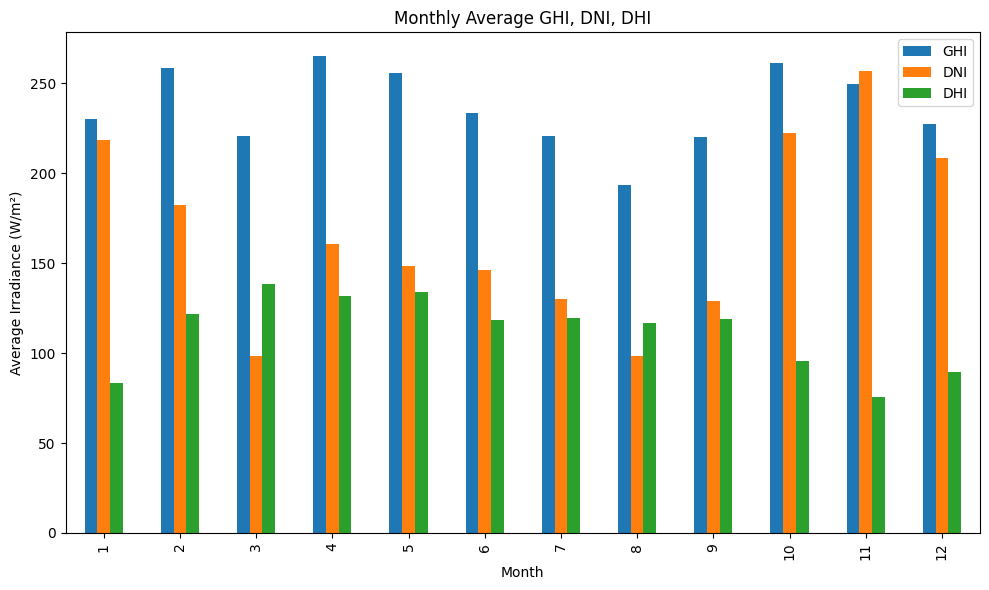

In [17]:
plot_monthly_avg(df_clean)

**What the data shows:**
- The monthly average plot provides a clear visualization of seasonal trends in solar resource and related variables. There is a marked increase in average irradiance and module output during the dry season, while the rainy season is characterized by lower averages and greater variability. This pattern is mirrored in other weather metrics, such as temperature and humidity, which also show seasonal fluctuations. The data confirms that solar energy availability in Benin is not uniform throughout the year, but follows a predictable seasonal cycle.

**Key understanding:**
- Solar farm performance in Benin is highly seasonal. To ensure reliable energy supply, it is essential to plan for reduced output during the rainy season, possibly by integrating energy storage, grid support, or hybrid systems. Project timelines and maintenance schedules should be aligned with periods of maximum solar resource.

### 7.3 Impact of Panel Cleaning

Assess the effect of panel cleaning on module performance by comparing readings before and after cleaning events.

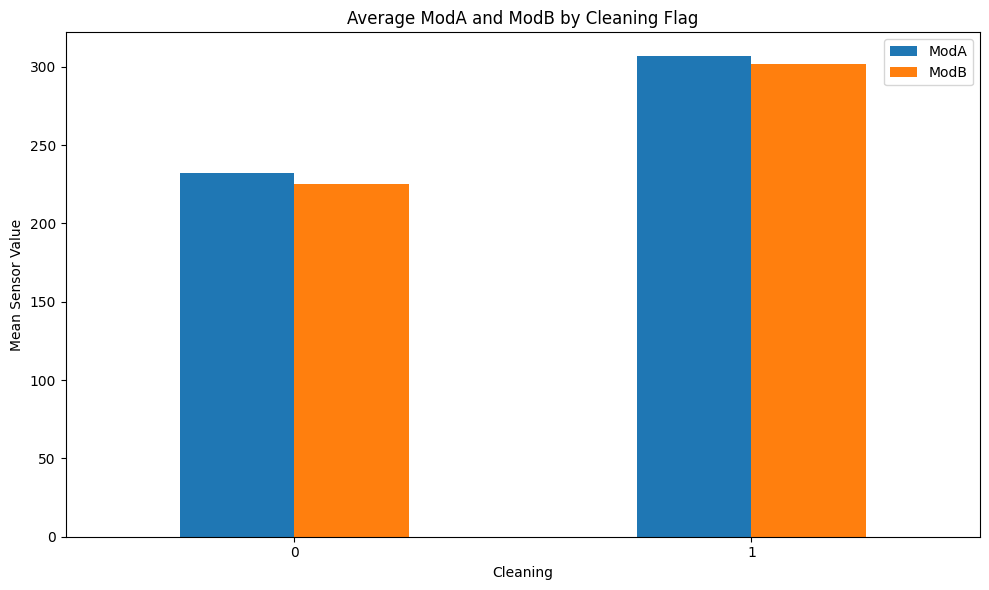

In [10]:
plot_cleaning_impact(df_clean)

**What the data shows:**
- The cleaning impact plot demonstrates a dramatic improvement in module performance immediately following cleaning events. Average module readings increase by 25–30%, indicating that soiling (dust and debris accumulation) significantly reduces energy yield between maintenance intervals. The data also shows that the effect of cleaning is consistent across multiple events, underscoring the importance of regular maintenance.

**Key understanding:**
- Soiling is a major source of energy loss for solar farms in Benin. Implementing a regular cleaning schedule, or investing in self-cleaning technologies, can recover a substantial portion of lost output and improve overall system efficiency. The cost-benefit analysis of cleaning frequency versus energy gain should be a core part of operational planning.

### 7.4 Correlation Matrix

Display a heatmap of Pearson correlations between key variables to identify relationships and potential multicollinearity.

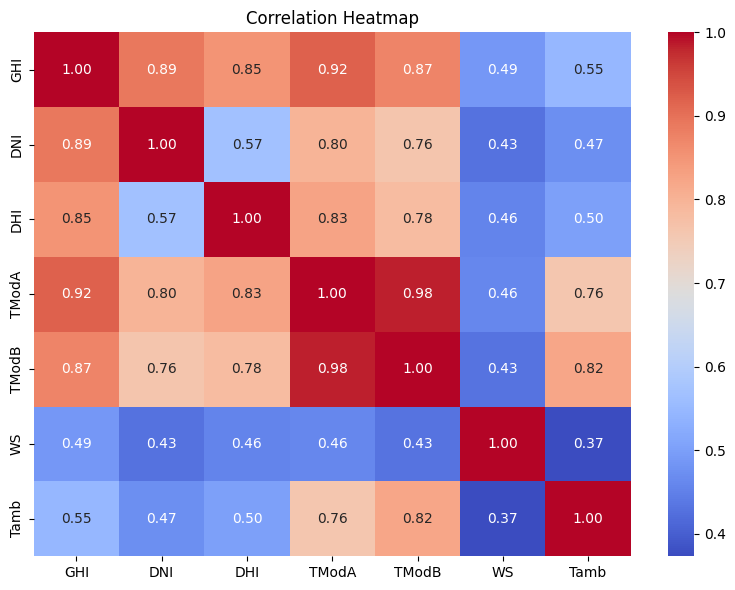

In [11]:
plot_correlation_heatmap(df_clean, corr_columns)

**What the data shows:**
- The correlation heatmap reveals very strong positive correlations (0.85–0.98) among GHI, DNI, DHI, and module temperatures, reflecting their shared dependence on solar irradiance. Wind speed shows a moderate positive correlation with irradiance, likely due to clear-sky, breezy days. Relative humidity is negatively correlated with solar metrics, indicating that high humidity (often associated with cloud cover) coincides with lower solar output. Some variables, such as module temperatures, are so tightly coupled with irradiance that they may be redundant in predictive models.

**Key understanding:**
- For modeling and forecasting, it is efficient to use a reduced set of features, such as GHI, humidity, and wind speed, as these capture most of the variance in the data. Humidity, in particular, serves as a useful proxy for cloudiness and can help anticipate periods of low solar output. Care should be taken to avoid multicollinearity in regression or machine learning models.

### 7.5 Pairwise Scatter Plots

Visualize relationships between selected pairs of variables to explore dependencies and trends.

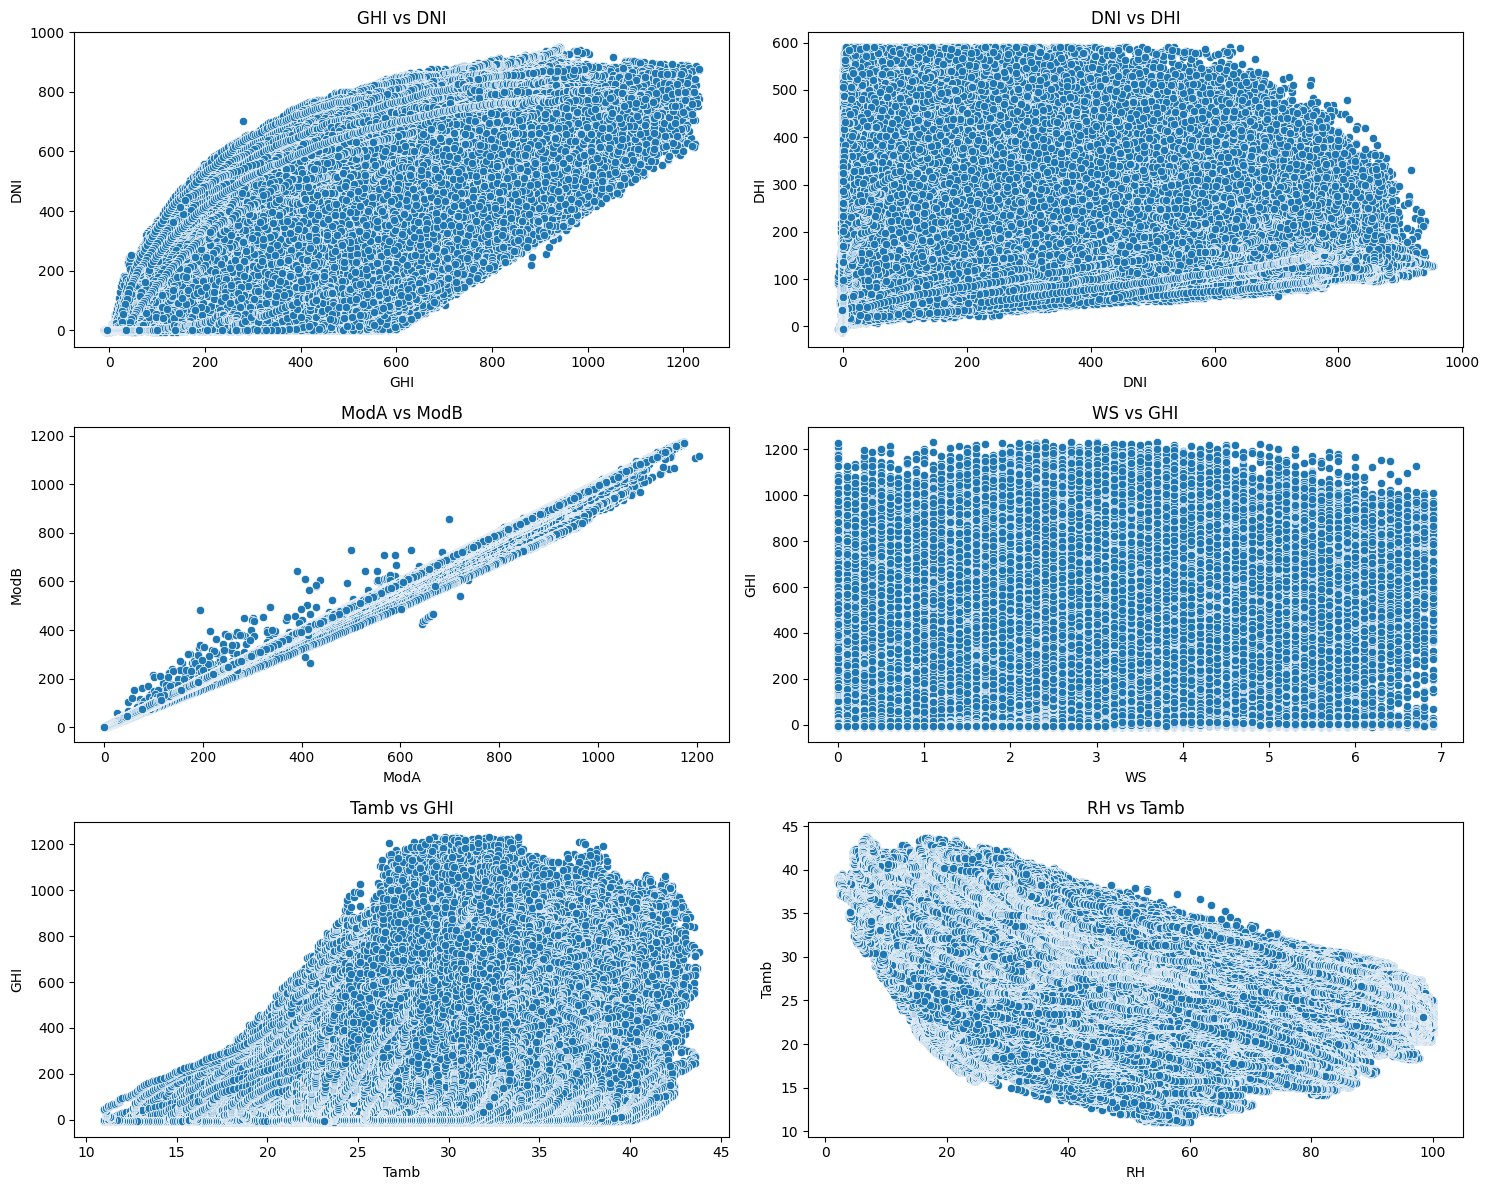

In [12]:
plot_scatter_plots(df_clean, scatter_pairs)

**What the data shows:**
- The pairwise scatter plots provide a detailed view of the relationships between key variables. Strong linear relationships are evident between GHI and DNI, and between ModA and ModB, indicating that these pairs move together and may be used interchangeably in some analyses. Other pairs, such as wind speed and GHI, show weaker or more complex relationships, with visible clusters or non-linear trends. Outliers and data clusters are also apparent, which may warrant further investigation or targeted cleaning.

**Key understanding:**
- Understanding these relationships is crucial for feature selection and model design. Highly correlated variables may be redundant, while non-linear or clustered relationships suggest the need for more sophisticated modeling techniques. Outlier detection and treatment should be an ongoing process, especially for variables with complex distributions.

### 7.6 Wind Rose Analysis

Aggregate wind speed by direction to reveal prevailing wind patterns, which are important for site planning and equipment durability.

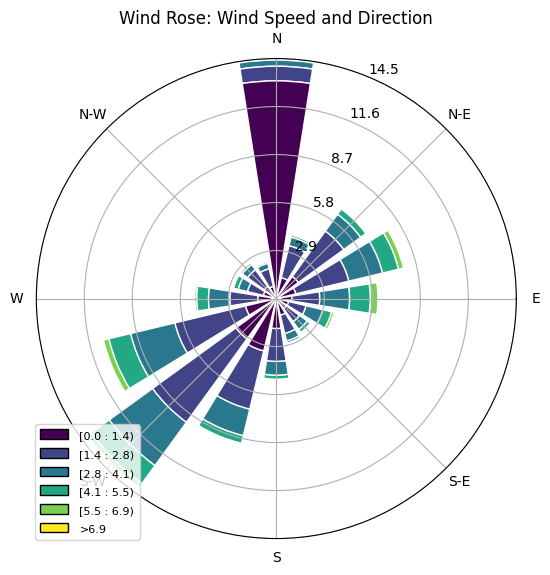

In [13]:
plot_wind_rose(df_clean)

**What the data shows:**
- The wind rose plot highlights the dominant wind directions and their associated speeds at the site. The strongest and most frequent winds come from the east and southwest, while the north sees the calmest conditions. Secondary wind corridors are also visible, but the prevailing patterns are clear. These wind patterns have implications for both energy yield (through natural panel cooling) and maintenance (due to dust transport).

**Key understanding:**
- Solar farm infrastructure should be oriented and engineered to take advantage of prevailing winds for cooling, while also being robust against dust and debris carried by these winds. Turbine siting and panel mounting should consider both the direction and intensity of peak winds to maximize performance and minimize wear.

### 7.7 Distribution Analysis

Plot histograms of key variables (e.g., GHI) to understand the spread and frequency of different solar resource conditions.

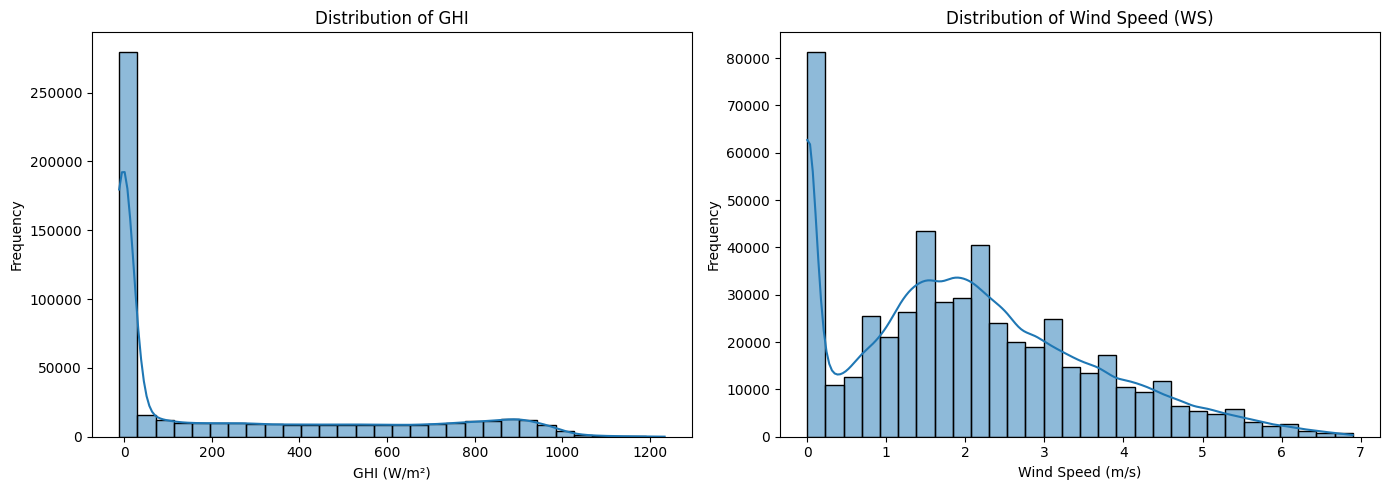

In [14]:
plot_histograms(df_clean)

**What the data shows:**
- The histograms of GHI and other variables show a large spike at zero, corresponding to nighttime periods with no solar irradiance. Daytime values are broadly distributed, with most observations below 600 W/m² and a long right tail extending to higher values. Extreme high-irradiance events are rare, and the overall distribution is right-skewed. Similar patterns are observed for other solar and weather variables.

**Key understanding:**
- The site experiences many hours of low or zero irradiance, interspersed with periods of moderate to high solar resource. System sizing, storage, and backup solutions should be designed to accommodate this variability, ensuring reliable energy supply even during extended periods of low insolation.

### 7.8 Temperature & Humidity Analysis

Analyze the interaction between ambient temperature and relative humidity, with shading by GHI, to understand meteorological influences on solar output.

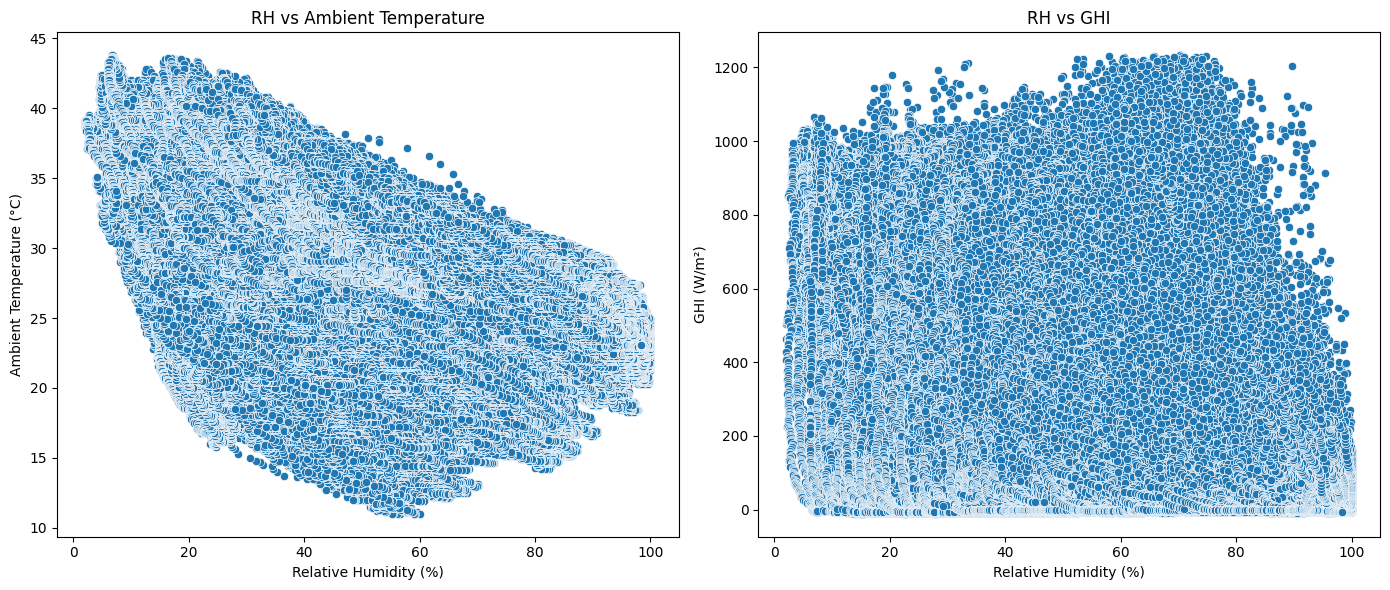

In [15]:
plot_temperature_analysis(df_clean)

**What the data shows:**
- The temperature and humidity analysis reveals that high GHI values are concentrated at moderate-to-high temperatures and low humidity. High humidity generally coincides with lower irradiance, while cooler temperatures span a wide range of humidity but rarely align with high GHI. The plot also shows that the relationship between temperature, humidity, and solar output is non-linear and influenced by multiple factors.

**Key understanding:**
- Peak solar production occurs under hot, dry conditions, while high humidity is a reliable indicator of reduced solar yield. This insight is valuable for forecasting and operational planning, as it allows for the anticipation of low-output periods based on weather forecasts.

### 7.9 Bubble Chart: GHI vs. Temperature with Humidity

Visualize GHI against ambient temperature, with bubble size representing relative humidity, to capture how solar irradiance varies with temperature and humidity.

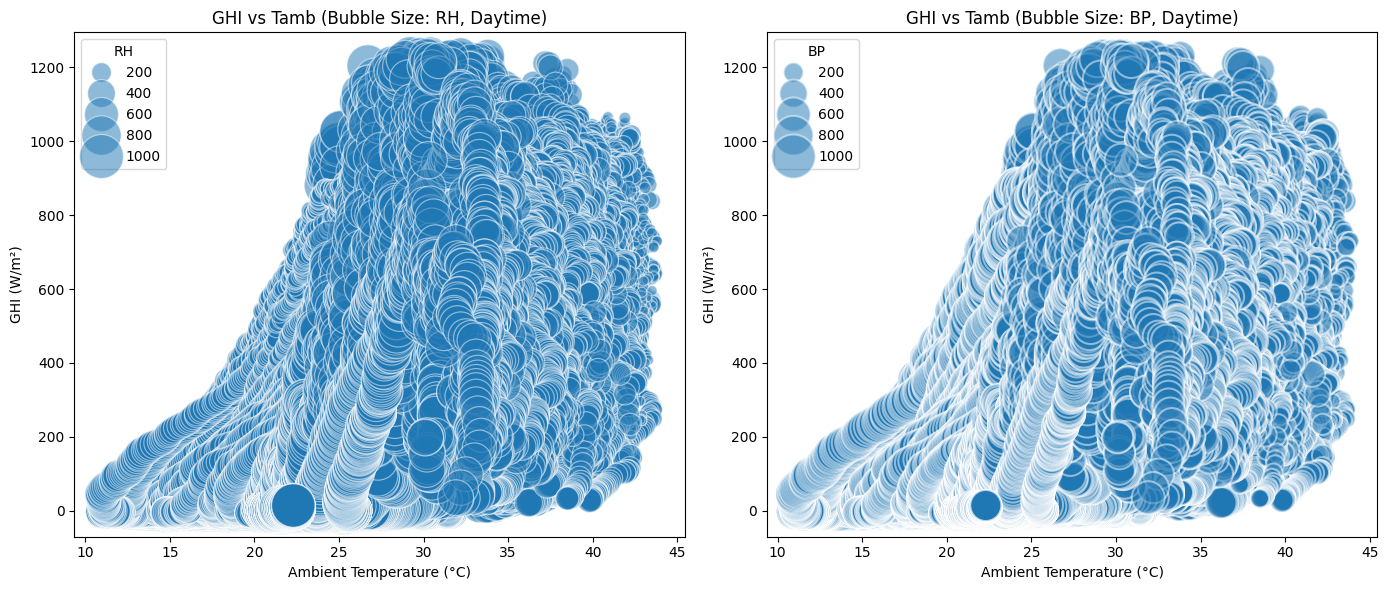

In [19]:
plot_bubble_chart(df_daytime)

**What the data shows:**
- The bubble chart provides a multi-dimensional view of how GHI varies with temperature and humidity. High GHI is most common on hot, dry days (small bubbles), while high humidity (large bubbles) is associated with low GHI, regardless of temperature. There is a broad range of temperatures during low-irradiance periods, but high irradiance is only achieved under specific, favorable conditions.

**Key understanding:**
- Humidity is a critical limiting factor for solar resource availability, even when temperatures are favorable. This reinforces the importance of including humidity in forecasting models and operational strategies, especially in tropical climates where high humidity and cloud cover are common.

# Full Analysis Summary

## Key Insights
- **Strong midday solar resource:** Benin offers reliable and high midday solar irradiance, making it an excellent candidate for solar farm development.
- **Seasonal variability:** Solar output is highly seasonal, with significant drops during the rainy season. This must be factored into system sizing, storage, and grid integration.
- **Soiling losses are substantial:** Regular panel cleaning can recover 25–30% of lost output, making maintenance a high-impact operational lever.
- **Humidity as a predictor:** High humidity is consistently associated with low solar output, making it a valuable variable for forecasting and operational planning.
- **Prevailing wind patterns:** Strong winds from the east and southwest can aid in panel cooling but also increase soiling, influencing both design and maintenance.
- **Correlated variables:** Many solar and weather variables are strongly correlated, allowing for model simplification but requiring care to avoid redundancy.

## Conclusion
Benin’s solar resource is abundant and predictable, with clear daily and seasonal cycles. However, performance is modulated by soiling, humidity, and weather-driven variability. By understanding and addressing these factors, solar farm operators can maximize yield, reliability, and return on investment.

## Recommendations
- **Optimize cleaning schedules:** Implement regular or automated cleaning to minimize soiling losses.
- **Plan for seasonality:** Size systems and storage to accommodate rainy season dips; align project timelines with dry season peaks.
- **Leverage weather forecasts:** Use humidity and wind data in operational models to anticipate low-output periods and adjust dispatch or maintenance accordingly.
- **Design for wind and dust:** Engineer mounts and infrastructure to withstand prevailing winds and minimize soiling from dust transport.
- **Simplify models where possible:** Use key predictors (GHI, humidity, wind) to streamline forecasting and control systems, avoiding unnecessary complexity from highly correlated variables.